In [1]:
%pylab inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)
!pwd

Populating the interactive namespace from numpy and matplotlib
netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/home/561/erd561/ACCESS-OM2-1-025-010deg-report/figures/Australia


In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

output_dir = '/home/561/erd561/figures/Australia/'
fig_name = nb_name[:-6]
fig_dir = output_dir + fig_name

output_ls = os.listdir(output_dir)
if fig_name not in output_ls:
    os.mkdir(fig_dir)
    
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(fig_dir, fig_name[0:4]+fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return    

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [4]:
%%time

from dask.distributed import Client
c = Client()
print(c)

<Client: scheduler='tcp://127.0.0.1:36714' processes=8 cores=8>
CPU times: user 549 ms, sys: 127 ms, total: 676 ms
Wall time: 2.71 s


**The function below** calculates the quasi-barotropic streamfunction for each simulation. In each case, we read in only the last IAF cycle, then we average over the standard time period.

In [5]:
%%time
latS = -70
latN = 20
lonW = 90-360
lonE = 180-360
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
time_units = exptdata.exptdict[ekey]['time_units']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
print(expt)
print(time_units)
print(n_files)
print(offset)
temp_01_month = cc.get_nc_variable(expt,'ocean.nc','temp',time_units=time_units,n=n_files,offset=offset).\
                            sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).\
                            sel(yt_ocean=slice(latS,latN)).\
                            sel(xt_ocean=slice(lonW,lonE)).\
                            sel(st_ocean=0,method='nearest')

temp_01_month.load()
print(temp_01_month)

01deg_jra55v13_iaf
days since 0001-01-01
None
None
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
<xarray.DataArray 'temp' (time: 300, yt_ocean: 1186, xt_ocean: 900)>
array([[[      nan,       nan, ..., 273.2834 , 273.28915],
        [      nan,       nan, ..., 273.3283 , 273.32913],
        ...,
        [297.29062, 297.22516, ..., 296.99734, 296.98264],
        [297.23898, 297.2167 , ..., 296.98074, 296.95886]],

       [[      nan,       nan, ..., 272.81653, 272.78738],
        [      nan,       nan, ..., 272.85275, 272.8095 ],
        ...,
        [297.4436 , 297.21423, ..., 296.58884, 296.58023],
        [297.4397 , 297.22632, ..., 296.57843, 296.56793]],

       ...,

       [[      nan,       nan, ..., 271.3473 , 271.3471 ],
        [      nan,       nan, ..., 271.34662, 271.34634],
        ...,
        [301.4287 , 301.43378, ..., 300.3649 , 300.37512],
        [301.376  , 301.3831 , ..., 300.3404 , 300.3514 ]],

       [[      nan,       nan,

In [6]:
temp_01 = temp_01_month.groupby('time.year').mean('time', skipna=True)
print(temp_01)
temp_01_mean = temp_01.mean(dim='year')
print(temp_01_mean)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'temp' (year: 25, yt_ocean: 1186, xt_ocean: 900)>
array([[[      nan,       nan, ..., 271.7264 , 271.72592],
        [      nan,       nan, ..., 271.73196, 271.729  ],
        ...,
        [300.60236, 300.52548, ..., 298.90384, 298.90314],
        [300.45926, 300.41058, ..., 298.88864, 298.88593]],

       [[      nan,       nan, ..., 271.43204, 271.43036],
        [      nan,       nan, ..., 271.4318 , 271.4304 ],
        ...,
        [300.4228 , 300.37872, ..., 299.55075, 299.54694],
        [300.26535, 300.2357 , ..., 299.51984, 299.51306]],

       ...,

       [[      nan,       nan, ..., 271.5356 , 271.53067],
        [      nan,       nan, ..., 271.53622, 271.5279 ],
        ...,
        [301.27817, 301.25903, ..., 299.60626, 299.61057],
        [301.22958, 301.19168, ..., 299.58273, 299.58508]],

       [[      nan,       nan, ..., 271.75876, 271.75757],
        [      nan,       nan, ..., 271.75613, 271.75504],
        ...,
        [301.19467, 301.19592, ...,

In [7]:
temp_01_anom = temp_01 - temp_01_mean
print(temp_01_anom)

<xarray.DataArray 'temp' (year: 25, yt_ocean: 1186, xt_ocean: 900)>
array([[[      nan,       nan, ...,  0.026672,  0.028351],
        [      nan,       nan, ...,  0.033569,  0.033264],
        ...,
        [-0.126648, -0.176086, ..., -0.735016, -0.730469],
        [-0.208832, -0.236847, ..., -0.736725, -0.733124]],

       [[      nan,       nan, ..., -0.2677  , -0.267212],
        [      nan,       nan, ..., -0.266602, -0.26535 ],
        ...,
        [-0.306213, -0.322845, ..., -0.088104, -0.08667 ],
        [-0.40274 , -0.411743, ..., -0.10553 , -0.105988]],

       ...,

       [[      nan,       nan, ..., -0.164124, -0.166901],
        [      nan,       nan, ..., -0.16217 , -0.167847],
        ...,
        [ 0.549164,  0.557465, ..., -0.032593, -0.023041],
        [ 0.561493,  0.54425 , ..., -0.042633, -0.033966]],

       [[      nan,       nan, ...,  0.059021,  0.059998],
        [      nan,       nan, ...,  0.057739,  0.059296],
        ...,
        [ 0.465668,  0.494354, ...,

[1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


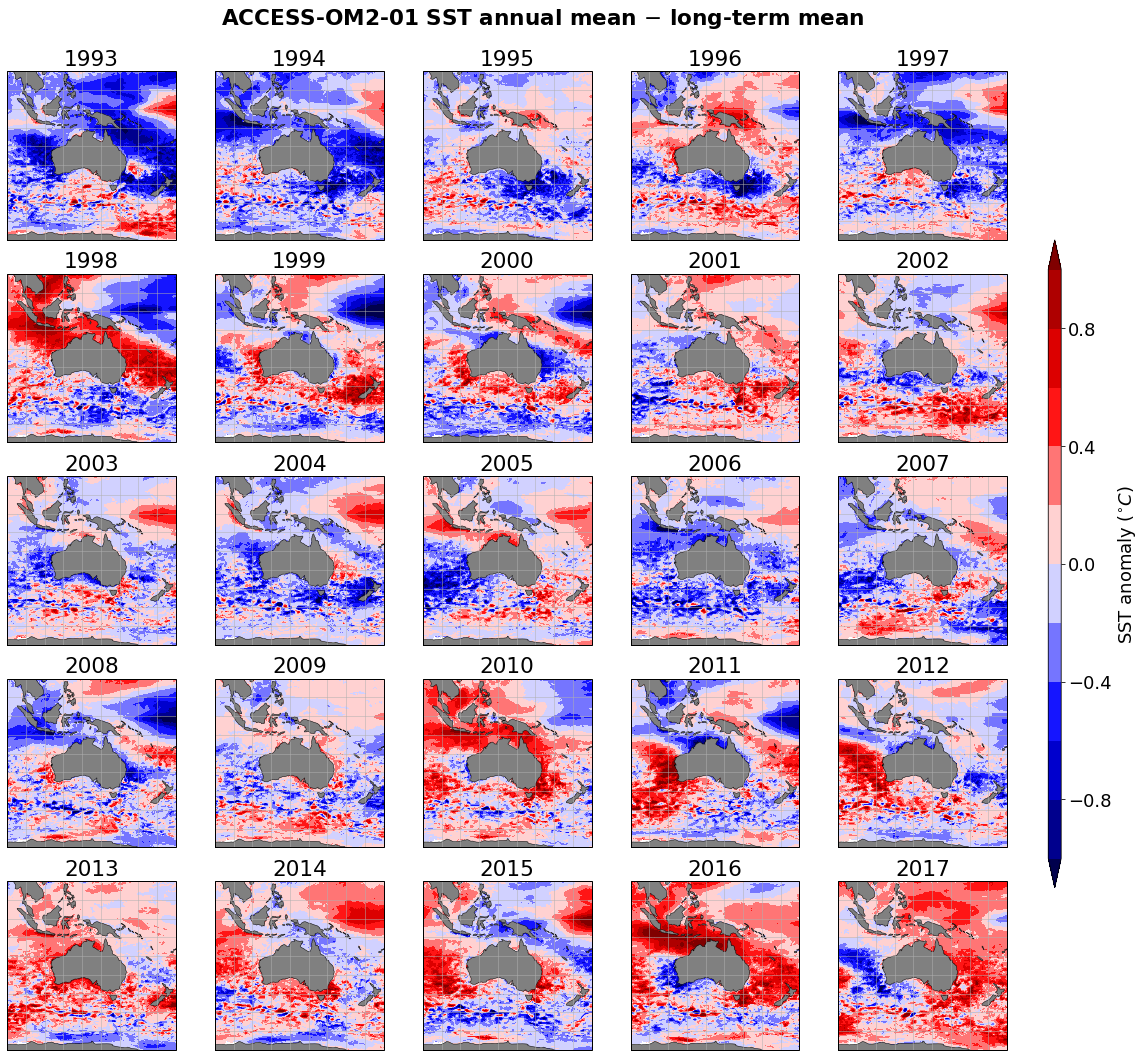

In [131]:
# General plotting stuff
plot_labels=['(a) ','(b) ','(c) ','(d)']
land_50m= cft.NaturalEarthFeature('physical', 'land', '110m',
                                    edgecolor='black',
                                    facecolor='gray',
                                    linewidth=0.5)
cmap = plt.get_cmap('seismic')
levels = arange(-1,1,0.2)
fig = plt.figure() 
fig.set_size_inches(18,18)
matplotlib.rcParams.update({'font.size': 18}) 
col = 5
row = 5

fig.suptitle('ACCESS-OM2-01 SST annual mean $-$ long-term mean', x=0.54, y=0.93, fontweight='bold')

year = temp_01_anom.year.values
print(year)
count = -1
for y in range(0,5):
    for x in range(0,5):
        count += 1
        print(year[count])
        ax = plt.subplot2grid((row, col), (y, x), rowspan=1, colspan=1, 
                              projection=ccrs.PlateCarree(central_longitude=0))
        ax.add_feature(land_50m)
        ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
        p = temp_01_anom.sel(year=year[count]).plot(add_colorbar=False, cmap=cmap, levels=levels, extend='both',)
        plt.title(year[count])
        ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

ax_cbar = plt.axes([0.93,0.25,0.01,0.5])
cbar = plt.colorbar(p,cax=ax_cbar,orientation='vertical')
cbar.ax.set_ylabel('SST anomaly ($^{\circ}C$)')
savefigure('anmean_diffw_ltmean')

In [8]:
temp_WOA13_01 = cc.get_nc_variable('woa13/01', 'woa13_ts_??_mom01.nc', 'temp').\
                            sel(ZT=0, method='nearest').\
                            sel(GRID_Y_T=slice(latS,latN)).\
                            sel(GRID_X_T=slice(lonW,lonE))
print(temp_WOA13_01)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
<xarray.DataArray 'temp' (time: 12, GRID_Y_T: 1186, GRID_X_T: 900)>
dask.array<shape=(12, 1186, 900), dtype=float64, chunksize=(1, 187, 200)>
Coordinates:
  * GRID_Y_T  (GRID_Y_T) float64 -70.0 -69.96 -69.92 ... 19.75 19.84 19.94
  * GRID_X_T  (GRID_X_T) float64 -269.9 -269.8 -269.7 ... -180.2 -180.1 -180.0
    ZT        float64 0.5413
  * time      (time) datetime64[ns] 1900-01-02 1900-01-03 ... 1900-01-13
Attributes:
    long_name:  potential temperature calculated using teos10 from objectivel...
    units:      degrees celsius


In [25]:
print(temp_01.year)

temp_WOA13_01.assign_coords(time=temp_01.year.values)


# temp_01_anom_WOA13 = temp_01 - temp_WOA13_01
print(temp_WOA13_01)

<xarray.DataArray 'year' (year: 25)>
array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017])
Coordinates:
    st_ocean  float64 0.5413
  * year      (year) int64 1993 1994 1995 1996 1997 ... 2013 2014 2015 2016 2017


ValueError: conflicting sizes for dimension 'time': length 12 on <this-array> and length 25 on 'time'

In [13]:
print(temp_01_anom_WOA13)
temp_01_anom_WOA13.sel().plot()

<xarray.DataArray 'temp' (year: 25, yt_ocean: 1186, xt_ocean: 900, time: 12, GRID_Y_T: 1186, GRID_X_T: 900)>
dask.array<shape=(25, 1186, 900, 12, 1186, 900), dtype=float64, chunksize=(25, 1186, 900, 1, 187, 200)>
Coordinates:
    st_ocean  float64 0.5413
  * xt_ocean  (xt_ocean) float64 -269.9 -269.8 -269.7 ... -180.2 -180.1 -180.0
  * yt_ocean  (yt_ocean) float64 -70.0 -69.96 -69.92 ... 19.75 19.84 19.94
  * year      (year) int64 1993 1994 1995 1996 1997 ... 2013 2014 2015 2016 2017
  * GRID_Y_T  (GRID_Y_T) float64 -70.0 -69.96 -69.92 ... 19.75 19.84 19.94
  * GRID_X_T  (GRID_X_T) float64 -269.9 -269.8 -269.7 ... -180.2 -180.1 -180.0
    ZT        float64 0.5413
  * time      (time) datetime64[ns] 1900-01-02 1900-01-03 ... 1900-01-13


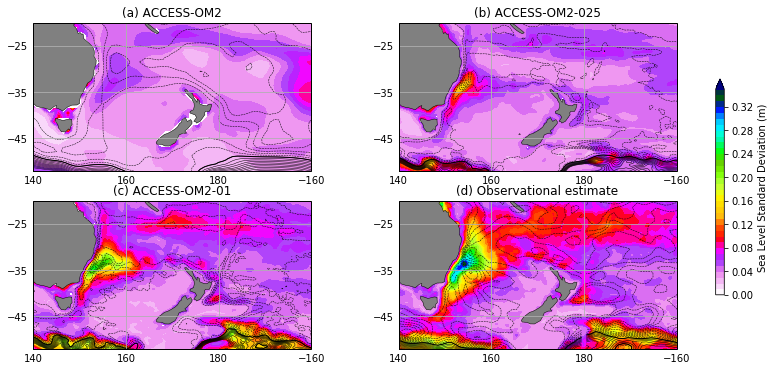

In [35]:
# EAC Region
plt.figure(figsize(12,6))
clev = np.arange(0,0.351,0.01)
clev2 = np.arange(-50,50.01,5)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    sla_rms = sla_rms_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-220, -160, -52, -20], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
    gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
    gl.xlabels_top = False
    gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
    gl.xlabels_top = False
    gl.ylabels_right = False
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='max', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])

ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-220, -160, -52, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
gl.xlabels_top = False
gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
gl.xlabels_top = False
gl.ylabels_right = False
p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(d) Observational estimate')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')
savefigure('eac_barotropic_streamfunctions')